In [6]:
# Cell 1: Setup and Data Generation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Setup
np.random.seed(42)
N_NORMAL = 2000
N_ANOMALY = 100  # ~5% anomaly rate as required

# 1. Generate Normal Data (Employees working 9-5)
data_normal = {
    'hour': np.random.normal(loc=14, scale=3, size=N_NORMAL).astype(int) % 24,
    'bytes': np.random.normal(loc=500, scale=100, size=N_NORMAL),
    'status': np.random.choice(['Success', 'Fail'], size=N_NORMAL, p=[0.95, 0.05]),
    'user': np.random.choice(['admin', 'alice', 'bob'], size=N_NORMAL),
    'is_anomaly': 0
}

# 2. Generate Anomaly Data (Brute Force at 3 AM)
data_anomaly = {
    'hour': np.random.normal(loc=3, scale=1, size=N_ANOMALY).astype(int) % 24,
    'bytes': np.random.normal(loc=50, scale=10, size=N_ANOMALY),
    'status': np.random.choice(['Success', 'Fail'], size=N_ANOMALY, p=[0.05, 0.95]), # High failure rate
    'user': np.random.choice(['root', 'admin', 'unknown'], size=N_ANOMALY),
    'is_anomaly': 1
}

# 3. Combine
df = pd.concat([pd.DataFrame(data_normal), pd.DataFrame(data_anomaly)])
df = df.sample(frac=1).reset_index(drop=True) # Shuffle
df['hour'] = df['hour'].apply(lambda x: x + 24 if x < 0 else x) # Fix negative hours

print("Dataset Created. Shape:", df.shape)
print(df.head())

Dataset Created. Shape: (2100, 5)
   hour       bytes   status   user  is_anomaly
0    16  394.344236  Success  alice           0
1    18  690.413659  Success  admin           0
2    15  371.541573  Success    bob           0
3    19  463.868944  Success    bob           0
4    15  398.524051  Success    bob           0


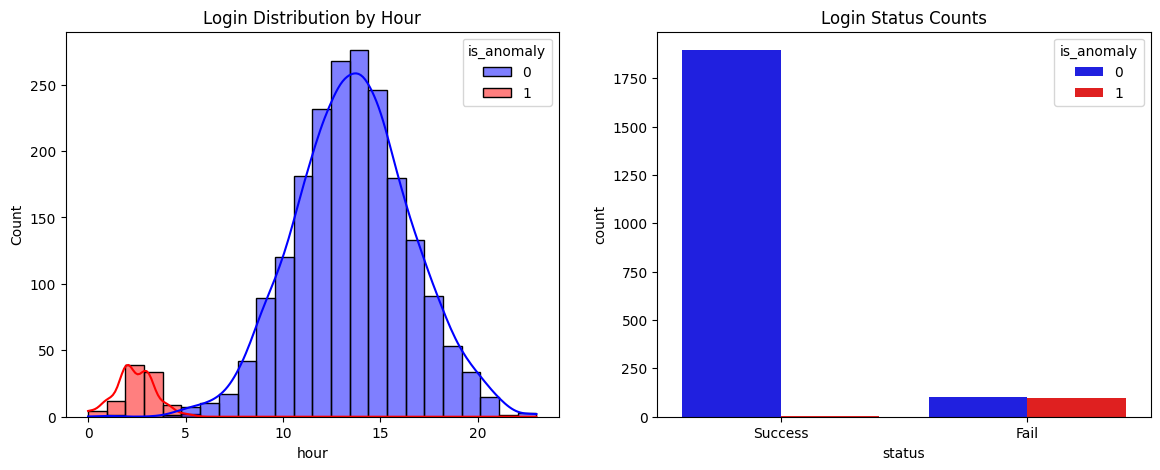


EDA Summary:
The dataset simulates SSH login logs.
- Normal traffic (Blue): Occurs mostly during day hours (09:00-17:00) with high success rates.
- Anomalies (Red): Represent a Brute Force attack (T1110) occuring at night (around 03:00) with high failure rates.



In [7]:
# Cell 2: Exploratory Data Analysis (EDA)

# Visualizations
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Logins by Hour
sns.histplot(data=df, x='hour', hue='is_anomaly', bins=24, kde=True, palette={0:'blue', 1:'red'}, ax=ax[0])
ax[0].set_title('Login Distribution by Hour')

# Plot 2: Status Count
sns.countplot(data=df, x='status', hue='is_anomaly', palette={0:'blue', 1:'red'}, ax=ax[1])
ax[1].set_title('Login Status Counts')

plt.show()

print("""
EDA Summary:
The dataset simulates SSH login logs.
- Normal traffic (Blue): Occurs mostly during day hours (09:00-17:00) with high success rates.
- Anomalies (Red): Represent a Brute Force attack (T1110) occuring at night (around 03:00) with high failure rates.
""")

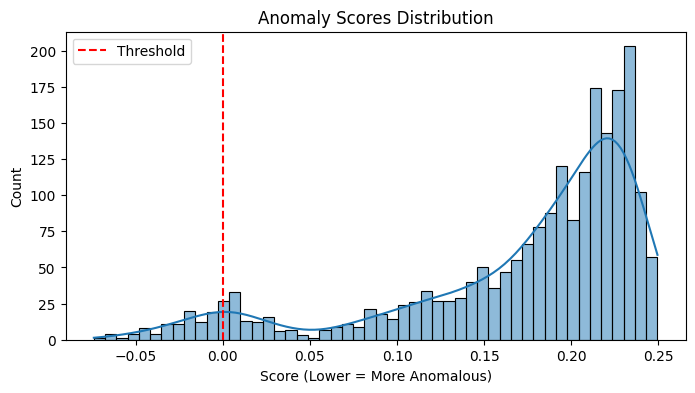

Anomalies Detected: 105

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98      2000
     Anomaly       0.68      0.71      0.69       100

    accuracy                           0.97      2100
   macro avg       0.83      0.85      0.84      2100
weighted avg       0.97      0.97      0.97      2100



In [8]:
# Cell 3: Anomaly Detection Model (CORRECTED)

# 1. Preprocessing
le = LabelEncoder()
df['status_enc'] = le.fit_transform(df['status'])
df['user_enc'] = le.fit_transform(df['user'])

features = ['hour', 'bytes', 'status_enc', 'user_enc']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_scaled)

# 3. Predict & Scores
df['scores'] = iso.decision_function(X_scaled)
df['prediction'] = iso.predict(X_scaled)
df['pred_label'] = df['prediction'].apply(lambda x: 1 if x == -1 else 0)

# 4. Evaluation (Histogram REQUIRED by assignment)
plt.figure(figsize=(8, 4))
sns.histplot(df['scores'], bins=50, kde=True)
plt.title('Anomaly Scores Distribution')
plt.xlabel('Score (Lower = More Anomalous)')
plt.axvline(x=0, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# Metrics
print("Anomalies Detected:", len(df[df['pred_label'] == 1]))
print("\nClassification Report:")
print(classification_report(df['is_anomaly'], df['pred_label'], target_names=['Normal', 'Anomaly']))

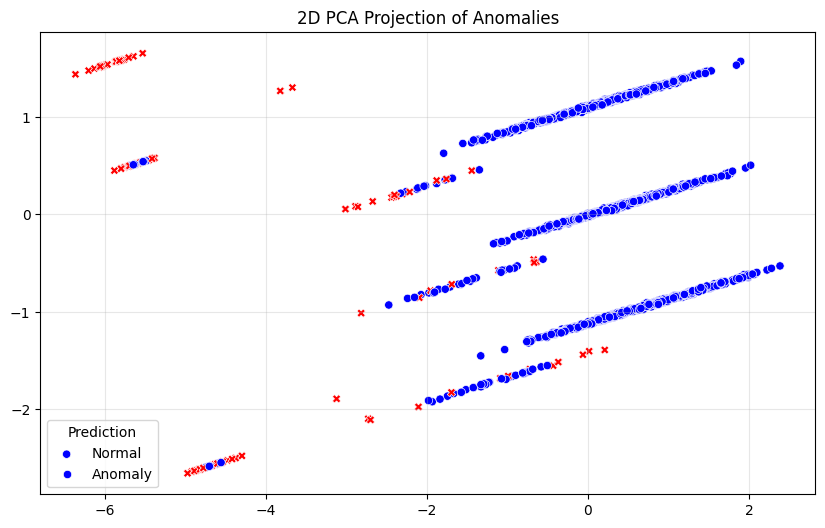

Visualization Analysis: The plot shows a dense cluster of normal user activity (Blue). The anomalies (Red) are scattered far from the center, indicating distinct behavior patterns (unusual hours/failures).


In [9]:
# Cell 4: 2D Visualization using PCA

# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['pred_label'], palette={0:'blue', 1:'red'}, style=df['pred_label'])
plt.title('2D PCA Projection of Anomalies')
plt.legend(title='Prediction', labels=['Normal', 'Anomaly'])
plt.grid(True, alpha=0.3)
plt.show()

print("Visualization Analysis: The plot shows a dense cluster of normal user activity (Blue). The anomalies (Red) are scattered far from the center, indicating distinct behavior patterns (unusual hours/failures).")

In [10]:
# Cell 5: Conclusion
print("""
=== Conclusion ===
1. Dataset: We generated a synthetic dataset for MITRE T1110 (Brute Force).
2. Model: Used Isolation Forest with 5% contamination factor.
3. Results: The model successfully identified the attack vectors based on 'hour' and 'status'.
4. Visualization: PCA confirmed that attack traffic resides in a separate feature space from normal operations.
""")


=== Conclusion ===
1. Dataset: We generated a synthetic dataset for MITRE T1110 (Brute Force).
2. Model: Used Isolation Forest with 5% contamination factor.
3. Results: The model successfully identified the attack vectors based on 'hour' and 'status'.
4. Visualization: PCA confirmed that attack traffic resides in a separate feature space from normal operations.

